#**Week -4**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [0]:
spark = SparkSession.builder.appName("ETL").getOrCreate()
spark

#**Loading data**

In [0]:
dfEmp = spark.read.csv(r"dbfs:/Volumes/workspace/default/datasets_fo/employees.csv", header=True, inferSchema=True)
dfPro = spark.read.csv(r"dbfs:/Volumes/workspace/default/datasets_fo/products.csv", header=True, inferSchema=True)
dfSal = spark.read.csv(r"dbfs:/Volumes/workspace/default/datasets_fo/sales.csv", header=True, inferSchema=True)
dfSto = spark.read.csv(r"dbfs:/Volumes/workspace/default/datasets_fo/stores.csv", header=True, inferSchema=True)

In [0]:
dfEmp.printSchema()

root
 |-- employeeID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- storeID: integer (nullable = true)
 |-- role: string (nullable = true)
 |-- hireDate: date (nullable = true)



In [0]:
dfPro.printSchema()

root
 |-- productID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- sellprice: double (nullable = true)
 |-- cost: double (nullable = true)
 |-- dateAdded: date (nullable = true)
 |-- Margin: double (nullable = true)
 |-- Margin %: double (nullable = true)



In [0]:
dfSal.printSchema()

root
 |-- saleID: integer (nullable = true)
 |-- productID: integer (nullable = true)
 |-- storeID: integer (nullable = true)
 |-- employeeID: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- saleDate: date (nullable = true)



In [0]:
dfSto.printSchema()

root
 |-- storeID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- region: string (nullable = true)
 |-- address: string (nullable = true)
 |-- createdAt: date (nullable = true)



#**Joining product + sales data**

In [0]:
dfProSales = dfPro.join(dfSal, on="productID", how="inner")

In [0]:
dfProSales = dfProSales.withColumn("daysToSell", F.date_diff(F.col("saleDate"), F.col("dateAdded")))

In [0]:
categoryReport = dfProSales.groupBy("category").agg(
    F.round(F.mean("Margin %"), 2).alias("averageMargin%"),
    F.round(F.mean("daysToSell"), 2).alias("averageDaysTakesToSell"),
    F.round(F.mean("Margin"), 2).alias("averageMarginINR"),
    F.round(F.mean("quantity"), 2).alias("averageQTYperBuy"),
    F.sum("quantity").alias("totalQuantitySold")
)
categoryReport.show()

+-----------+--------------+----------------------+----------------+----------------+-----------------+
|   category|averageMargin%|averageDaysTakesToSell|averageMarginINR|averageQTYperBuy|totalQuantitySold|
+-----------+--------------+----------------------+----------------+----------------+-----------------+
|Accessories|         32.78|                 82.67|           15.67|            5.33|               16|
|  Furniture|         25.93|                 108.0|            52.5|             3.0|                6|
| Home Goods|         26.19|                  52.0|            14.0|           10.67|               32|
|    Apparel|         47.62|                  46.5|            13.0|            19.0|               38|
|   Footwear|          25.0|                  31.0|            15.0|             3.0|                3|
|    Grocery|         30.55|                  62.0|             1.0|            53.0|              159|
|Electronics|         18.57|                  72.0|           50

#**Saving final metrics**

In [0]:
categoryReport.write.mode("overwrite").csv(r"dbfs:/Volumes/workspace/default/datasets_fo/categoryReport")

#**SQL**

In [0]:
spark.sql("CREATE DATABASE product_sales")
spark.sql("USE product_sales")

DataFrame[]

In [0]:
dfProSales.write.mode("overwrite").saveAsTable("product_sales.pro_sales")

In [0]:
prodReport = spark.sql("""
          SELECT productID, name, SUM(quantity) AS SoldQty, SUM(Margin * quantity) AS RevenueGenerated FROM pro_sales
          GROUP BY productID, name
          ORDER BY SUM(quantity) DESC
          LIMIT 3
          """)
prodReport.show()

+---------+-----------------+-------+----------------+
|productID|             name|SoldQty|RevenueGenerated|
+---------+-----------------+-------+----------------+
|        2|   Organic Apples|    100|           100.0|
|        9|Whole Wheat Bread|     50|            25.0|
|        3|   Cotton T-Shirt|     30|           330.0|
+---------+-----------------+-------+----------------+



#**Deliverables**
- databricks notebook with ETL logic
- saved output files for dashboard use

In [0]:
# 1. databricks notebook is saved in .ipynb format in week-4 of project in git repo

In [0]:
# 2. saving output files for dashboard use
prodReport.write.mode("overwrite").csv(r"dbfs:/Volumes/workspace/default/datasets_fo/productMetrics")

categoryReport.write.mode("overwrite").csv(r"dbfs:/Volumes/workspace/default/datasets_fo/categoryMetrics")

#**Basic Visualization**

In [0]:
visual_1 = prodReport.toPandas()
visual_2 = categoryReport.toPandas()

<Axes: xlabel='name'>

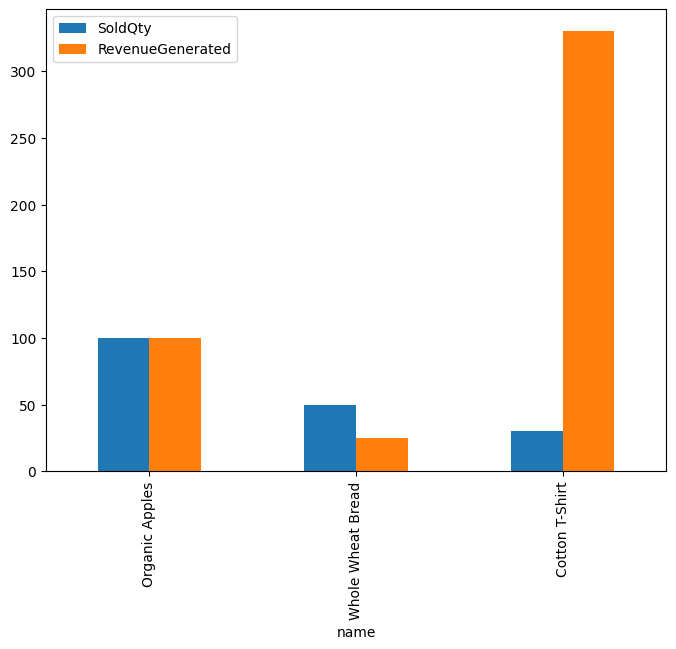

In [0]:
visual_1.plot.bar(x="name", y=["SoldQty", "RevenueGenerated"], figsize=(8, 6))

<Axes: xlabel='category'>

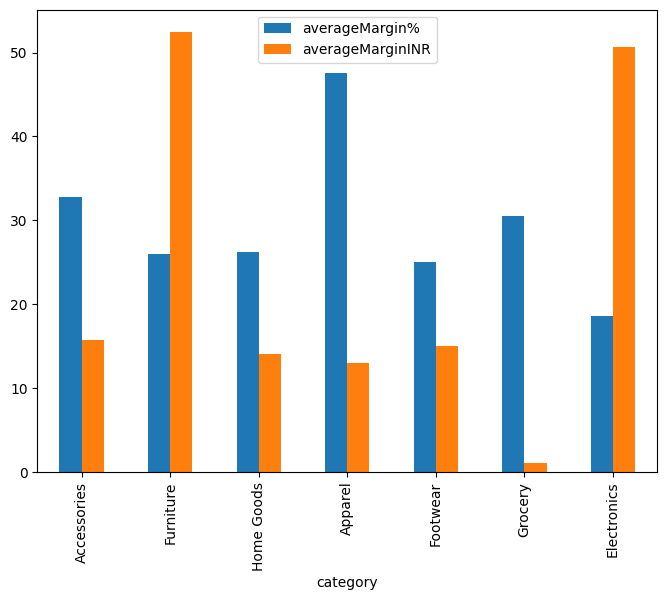

In [0]:
visual_2.plot.bar(x="category", y=["averageMargin%", "averageMarginINR"], figsize=(8, 6))

<Axes: xlabel='category'>

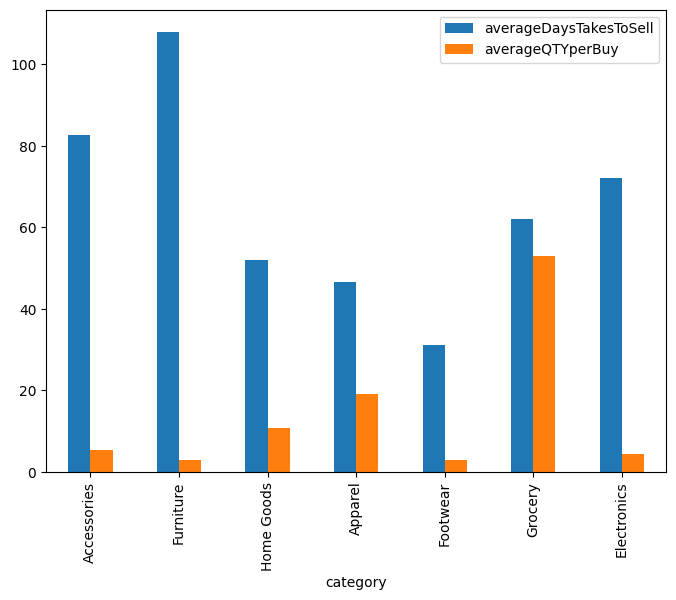

In [0]:
visual_2.plot.bar(x="category", y=["averageDaysTakesToSell", "averageQTYperBuy"], figsize=(8, 6))

<Axes: ylabel='totalQuantitySold'>

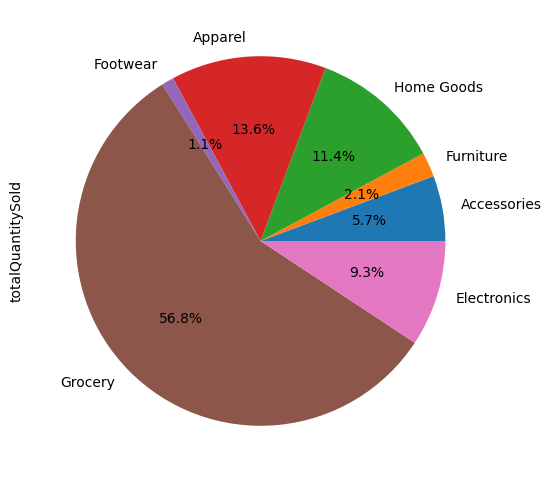

In [0]:
visual_2.set_index("category")["totalQuantitySold"].plot.pie(autopct="%1.1f%%", figsize=(8, 6))